In [1]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Point

import sys
sys.path.insert(0, '../src/processing/')
import tools
import os.path
import definitions

## Introduction <a name="introduction"></a>
With the vast amount of CTA bus location data I have collected so far in 2019, I want to develop a process for analyzing the data on a neighborhood and city level. My aim is to measure and compare the quality of bus service within each [Chicago community area](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) and on each "Side" of town. In this notebook, I begin to develop this process by analyzing the bus routes which travel through Logan Square, specifically examining their service as they traverse the neighborhood. For different blocks of time during the day, I calculate the mean wait time for each bus route in Logan Square and proportion of trips which experience bus bunching. 

### Load the community areas into a `GeoDataFrame`
The geospatial boundaries of Chicago's 77 community areas can be found at the [Chicago Data Portal](https://data.cityofchicago.org/). 

In [2]:
commareas = gpd.read_file("../data/raw/geofences/Boundaries - Community Areas (current).geojson")
commareas.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,(POLYGON ((-87.60914087617894 41.8446925026539...
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,(POLYGON ((-87.59215283879394 41.8169293462668...
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,(POLYGON ((-87.62879823733725 41.8018930336891...
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,(POLYGON ((-87.6067081256125 41.81681377057218...
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,(POLYGON ((-87.59215283879394 41.8169293462668...


In [3]:
losq = commareas[commareas.community == "LOGAN SQUARE"]

### Load the bus patterns into a `GeoDataFrame`
To start, I try to get the code working using data from Route 73 Armitage.

Next, I want to load the route's pattern data, which details the locations of each bus stop. The plan is to identify only those bus stops which are in Logan Square by performing a spatial join on `GeoDataFrames` containing each data set, so I can restrict the analysis of the wait times to just the one neighborhood. Since the pattern data is not saved in a geospatial file format---they are in regular JSON files---I cannot directly load it into a `GeoDataFrame`. I first load it into a regular `DataFrame`, then create geometry objects using the latitude and longitudes columns, and finally load the `DataFrame` and geometry into a `GeoDataFrame`.

In [4]:
patterns = tools.load_patterns(73, False)
patterns.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir
0,41.913547,-87.633030,287.0,4,1451,Clark & Lasalle,S,36853.0,2169,Westbound
1,41.915565,-87.634193,1024.0,6,1905,Clark & Lincoln,S,36853.0,2169,Westbound
2,41.916687,-87.634905,1470.0,8,1906,Clark & Wisconsin,S,36853.0,2169,Westbound
3,41.918220,-87.636368,2359.0,14,13180,Armitage & Clark,S,36853.0,2169,Westbound
4,41.918212,-87.639118,3097.0,17,4084,Armitage & Lincoln/Sedgwick,S,36853.0,2169,Westbound


In [5]:
geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
patterns_gdf = gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})
patterns_gdf.head()

,lat,lon,pdist,seq,stpid,stpnm,typ,ln,pid,rtdir,geometry
0,41.913547,-87.633030,287.0,4,1451,Clark & Lasalle,S,36853.0,2169,Westbound,POINT (-87.633029999999 41.913547)
1,41.915565,-87.634193,1024.0,6,1905,Clark & Lincoln,S,36853.0,2169,Westbound,POINT (-87.634193000002 41.915564999999)
2,41.916687,-87.634905,1470.0,8,1906,Clark & Wisconsin,S,36853.0,2169,Westbound,POINT (-87.634904999998 41.916687)
3,41.918220,-87.636368,2359.0,14,13180,Armitage & Clark,S,36853.0,2169,Westbound,POINT (-87.63636800000199 41.918219999999)
4,41.918212,-87.639118,3097.0,17,4084,Armitage & Lincoln/Sedgwick,S,36853.0,2169,Westbound,POINT (-87.63911799999801 41.918212000001)


### Perform a spatial join on the two geometry objects
Intersect the bus stop geometry (Points) with the neighborhood geomery (Polygon) to select only those bus stops in Logan Square.

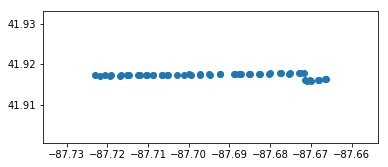

In [6]:
losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")
losq_stops.plot()

### Load the travel and wait times into a `DataFrame`
I load the travel and wait times data for Route 73 Armitage (and abitrarily choose to just work with the data for westbound trips in January for now).

Because bus service varies throughout the day, it makes sense to analyze bus service during different time intervals. I bin the data into two-hour intervals from 5AM to 11PM. This may not end up being a good way to bin the data, but it is a useful starting point.

I also go ahead and drop all of the rows where the origin bus stop is not within Logan Square, as well as all of the unnecessary travel time columns.

In [7]:
travels_waits = tools.load_travels_waits(73, "Westbound", "201901")
travels_waits.head()

,1451,1905,1906,13180,4084,4085,4086,4087,4088,4089,...,4137,4138,3883,14179,start_date,pid,tatripid,decimal_time,wait|14179,origin
0,NaN,0.52,0.85,1.60,2.53,2.85,3.30,3.77,4.28,4.87,...,33.48,34.22,34.98,35.15,2019-01-01,2169,2,7.05,49.65,1451
1,NaN,0.42,0.77,1.32,1.80,2.33,3.02,3.43,3.90,4.53,...,27.63,28.23,NaN,NaN,2019-01-01,2169,8,7.87,14.37,1451
2,NaN,0.72,1.00,2.17,3.57,3.97,4.52,5.05,6.32,7.92,...,33.40,34.17,34.92,35.07,2019-01-01,2169,9,8.12,20.97,1451
3,NaN,0.63,1.02,1.75,2.27,2.70,3.30,3.83,4.40,5.10,...,32.50,32.90,33.47,33.75,2019-01-01,2169,10,8.47,23.68,1451
4,NaN,0.20,0.38,0.82,1.37,1.73,2.17,2.55,3.10,4.12,...,28.75,29.62,37.27,37.45,2019-01-01,2169,14,8.85,25.22,1451


In [8]:
travels_waits["bins"] = pd.cut(travels_waits.decimal_time, np.arange(5, 24, 2), labels=np.arange(5, 23, 2), right=False)
travels_waits = travels_waits.loc[:,'start_date':]
travels_waits.drop(travels_waits[~travels_waits.origin.isin(losq_stops.stpid)].index, inplace=True)
travels_waits.head()

,start_date,pid,tatripid,decimal_time,wait|14179,origin,bins
27526,2019-01-01,2169,2,7.22,19.72,4095,7
27527,2019-01-01,2169,7,7.53,28.32,4095,7
27528,2019-01-01,2169,8,8.02,18.57,4095,7
27529,2019-01-01,2169,9,8.32,17.25,4095,7
27530,2019-01-01,2169,10,8.62,22.60,4095,7


### Calculate the wait times between buses on a particular route in Logan Square
As a bus works its route, the wait time between it and the next bus will vary from stop to stop. To find the wait times between Armitage buses not at a particular bus stop but anywhere in Logan Square, I calculate the average wait time on the set of Logan Square bus stops for each trip. As explained in the documentation, each trip is uniquely identified by its "start_date", "pid", and "tatripid".

Note: For each departure from an origin stop, the travels_waits `DataFrame` gives the wait time (in minutes) for the next bus heading to a particular terminal stop to arrive at that origin stop. Since some routes have more than one terminus, there may be more than one calculated wait time. Each column "wait|STPID_1", ..., "wait|STPID_N" gives the wait time for the next bus heading to some terminal with `stpid` STPID_M.

In [9]:
waits_cols = travels_waits.columns[travels_waits.columns.str.contains("wait\|")]
grouped = travels_waits.groupby(["start_date", "pid", "tatripid", "bins"])[waits_cols].mean().reset_index()

### Calculate the average wait time for a particular bus route in Logan Square by direction of travel and time of day
The travels_waits data files are already separated by direction of travel. Explicitly naming and grouping by the direction of travel is just for convenience.

In [10]:
grouped["rtdir"] = "Westbound"
grouped.groupby(["rtdir", "bins"])[waits_cols].mean()
print grouped.groupby(["rtdir", "bins"])[waits_cols].mean()

                wait|14179
rtdir     bins            
Westbound 5      19.781730
          7      12.873016
          9      12.917799
          11     19.827373
          13     18.559086
          15     13.885295
          17     14.573795
          19     20.832703
          21     22.952353


### To find the proportion of trips that were "bunched", first count the number of bunching incidents during each time interval
To start, we'll arbitrary mark any trip as "bunched" if the wait time between it and the next bus is less than 2 minutes. In the future, we can define bus bunching in a more nuanced way--such as defining the threshold in terms of the scheduled wait time--but this definition works for this first-round analysis.

In [11]:
masked = grouped.copy()
masked[waits_cols] = (masked[waits_cols] < 2)
masked.groupby(["rtdir", "bins"])[waits_cols].sum()

wait|14179
rtdir     bins            
Westbound 5            0.0
          7            4.0
          9            3.0
          11           0.0
          13           0.0
          15           3.0
          17           6.0
          19           0.0
          21           0.0

### Then calculate the total number of trips during each time interval

In [12]:
grouped.groupby(["rtdir", "bins"])[waits_cols].count()

wait|14179
rtdir     bins            
Westbound 5            150
          7            324
          9            340
          11           226
          13           239
          15           325
          17           312
          19           165
          21            96

### Divide the number of incidents by the total number of trips

In [13]:
masked.groupby(["rtdir", "bins"])[waits_cols].sum() / grouped.groupby(["rtdir", "bins"])[waits_cols].count()

wait|14179
rtdir     bins            
Westbound 5       0.000000
          7       0.012346
          9       0.008824
          11      0.000000
          13      0.000000
          15      0.009231
          17      0.019231
          19      0.000000
          21      0.000000

### Combine the above lines of code into a single for-loop

In [14]:
dates = [
    "201901",
    "201902",
    "201903",
    "201904",
]

rts = ["49","X49","52","53","56","73","74","76","82"]

In [17]:
cta_holidays = pd.DatetimeIndex(definitions.HOLIDAYS)

for rt in rts:
    patterns = tools.load_patterns(rt, False)
    geometry = [Point(xy) for xy in zip(patterns.lon, patterns.lat)]
    patterns_gdf = gpd.GeoDataFrame(patterns, geometry=geometry, crs={'init': 'epsg:4326'})
    losq_stops = gpd.sjoin(patterns_gdf, losq, how="inner", op="intersects")
    
    colname_map = {"wait|{}".format(stpid): "wait|{}".format(stpnm) for stpid, stpnm in zip(patterns.stpid, patterns.stpnm)}
    for rtdir in losq_stops.rtdir.unique():      
        tws = pd.concat((tools.load_travels_waits(rt, rtdir.lower(), d) for d in dates[:1]))

        tws.drop(tws[(tws.start_date.dt.dayofweek >= 5) | tws.start_date.isin(cta_holidays)].index, inplace=True)
        tws.drop(tws[~tws.origin.isin(losq_stops.stpid)].index, inplace=True)
        tws.dropna(axis='columns', how='all', inplace=True)

        waits_cols = tws.columns[tws.columns.str.contains("wait\|")]
        tws["bins"] = pd.cut(tws.decimal_time, np.arange(5, 24, 2), labels=np.arange(5, 23, 2), right=False)  

        rt_waits = tws.groupby(["start_date", "pid", "tatripid", "bins"])[waits_cols].mean().reset_index()
        rt_waits["rtdir"] = rtdir

        bunched = rt_waits.copy()
        bunched[waits_cols] = (bunched[waits_cols] < 2)
        bunching_incidents = bunched.groupby(["rtdir", "bins"])[waits_cols].sum()
        tot_trips = rt_waits.groupby(["rtdir", "bins"])[waits_cols].count()

        rt_mean_waits = rt_waits.groupby(["rtdir", "bins"])[waits_cols].mean()
        rt_bunching = bunching_incidents / tot_trips
        
        print rt, rtdir
        print rt_mean_waits.rename(columns=colname_map)
        print "bus bunching statistics"
        print rt_bunching.rename(columns=colname_map)

49 Northbound
                 wait|Western & Berwyn Terminal
rtdir      bins                                
Northbound 5                          13.924632
           7                          13.042781
           9                           9.909347
           11                          8.466208
           13                          8.456972
           15                         10.681285
           17                         10.010314
           19                          9.242289
           21                         20.085757
bus bunching statistics
                 wait|Western & Berwyn Terminal
rtdir      bins                                
Northbound 5                           0.010695
           7                           0.022936
           9                           0.089552
           11                          0.083333
           13                          0.089337
           15                          0.086643
           17                          0.140741
  

In [ ]:
'''losq_mean_waits = []
losq_bunching = []
losq_mean_waits.append(rt_mean_waits)
losq_bunching.append(rt_bunching)'''